<a href="https://www.kaggle.com/code/developersystem/generador-de-poema-con-redes-transformers?scriptVersionId=134947737" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Generación de poema usando FastAI


Ajustaremos un modelo de transformer preentrenado de la biblioteca transformers de HuggingFace. Puede ser muy sencillo con los cargadores de datos de FastAI. Es posible utilizar cualquiera de los modelos preentrenados de HuggingFace. A continuación, experimentaremos con GPT2.

## Importamos Librerias


In [1]:
# from fastbook import *
from fastai.text.all import *
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

In [2]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

## Cargamos data
Estos datos están organizados por carpetas. Hay dos carpetas principales: forms (por ejemplo, haiku, soneto, etc.) y topics (por ejemplo, amor, paz, etc.). Esas carpetas principales contienen subcarpetas para las subcategorías y luego los archivos de texto de los poemas se encuentran dentro de ellas.
Con FastAI, es bastante fácil leer los datos con la función get_text_files. Puedes seleccionar todas las carpetas o seleccionar específicas.

In [3]:
path = '../input/poemsdataset'

In [4]:
poems = get_text_files(path, folders = ['forms','topics'])
print("There are",len(poems),"poems in the dataset")

There are 20657 poems in the dataset


Comenzaremos entrenando el modelo con baladas. Solo hay 100 baladas, por lo que no tomará mucho tiempo entrenar. Sin embargo, puedes agregar más formas de poema. Por ejemplo, sería muy interesante experimentar con un haiku y ver si se mantiene la estructura de 5, 7, 5 sílabas. También puedes cambiar la ruta a la carpeta de temas en lugar de la de formas de poema, y probar con una variedad de temas de poema como amor, ira, depresión, etc.

In [5]:
ballads = get_text_files(path+'/forms', folders = ['ballad'])
print("There are",len(ballads),"ballads in the dataset")

There are 100 ballads in the dataset


In [6]:
txt = poems[0].open().read(); #read the first file
print(txt)

Lay a garland on my hearse,
Of the dismal yew,
Maidens, willow branches bear,
Say I died true.
My love was false, but I was firm
From my hour of birth;
Upon my buried body lie
Lightly, gentle earth.


## Preparamos la data



In [7]:
ballads = L(o.open().read() for o in ballads) # to make things easy we will gather all texts in one numpy array

In [8]:
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt
  
all_ballads = flatten(ballads)

In [9]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [10]:
splits = [range_of(70), range(100)] # use a 70/30 split
tls = TfmdLists(all_ballads, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [11]:
show_at(tls.train, 0)

DOWN harvest headlands the fairy host
Of the poppy banners have flashed and fled,
The lilies have faded like ghost and ghost,
The ripe rose rots in the garden bed.
The grain is garnered, the blooms are shed,
Convolvulus springs on the snowdrop’s bier,
In her stranded gold is the silver thread
Of the first grey hair i’ the head o’ the year.
Like an arrant knave from a bootless boast,
The fire-wind back to his North has sped
To harry the manes of a haunted coast
On a far sea-rim where the stars are dead.
Wistful the welkin with wordless dread,
Mournful the uplands, all ashen sere—
Sad for the snow on a beauteous head—
For the first grey hair i’ the head o’ the year.
Time trysts with Death at the finger-post,
Where the broken issues of life are wed—
Intone no dirges, fill up the toast
To the troops that trip it with silent tread,
Merry we’ll make it tho’ skies be lead,
And March-wind’s moan be a minstrel drear—
A truce to trouble!—we’ll drink instead
To the first grey hair i’ the head o’ 

In [12]:
bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

Token indices sequence length is longer than the specified maximum sequence length for this model (1170 > 1024). Running this sequence through the model will result in indexing errors


In [13]:
dls.show_batch(max_n=2)

,text,text_
0,"DEDICATION\nOf great limbs gone to chaos,\nA great face turned to night--\nWhy bend above a shapeless shroud\nSeeking in such archaic cloud\nSight of strong lords and light?\nWhere seven sunken Englands\nLie buried one by one,\nWhy should one idle spade, I wonder,\nShake up the dust of thanes like thunder\nTo smoke and choke the sun?\nIn cloud of clay so cast to heaven\nWhat shape shall man discern?\nThese lords may light the mystery\nOf mastery or victory,\nAnd these ride high in history,\nBut these shall not return.\nGored on the Norman gonfalon\nThe Golden Dragon died:\nWe shall not wake with ballad strings\nThe good time of the smaller things,\nWe shall not see the holy kings\nRide down by Severn side.\nStiff, strange, and quaintly coloured\nAs the broidery of Bayeux\nThe England of that dawn remains,\nAnd this of Alfred and the Danes\nSeems like the tales a whole tribe feigns\nToo English to be true.\nOf a good king on an island\nThat ruled once on a time;\n","EDICATION\nOf great limbs gone to chaos,\nA great face turned to night--\nWhy bend above a shapeless shroud\nSeeking in such archaic cloud\nSight of strong lords and light?\nWhere seven sunken Englands\nLie buried one by one,\nWhy should one idle spade, I wonder,\nShake up the dust of thanes like thunder\nTo smoke and choke the sun?\nIn cloud of clay so cast to heaven\nWhat shape shall man discern?\nThese lords may light the mystery\nOf mastery or victory,\nAnd these ride high in history,\nBut these shall not return.\nGored on the Norman gonfalon\nThe Golden Dragon died:\nWe shall not wake with ballad strings\nThe good time of the smaller things,\nWe shall not see the holy kings\nRide down by Severn side.\nStiff, strange, and quaintly coloured\nAs the broidery of Bayeux\nThe England of that dawn remains,\nAnd this of Alfred and the Danes\nSeems like the tales a whole tribe feigns\nToo English to be true.\nOf a good king on an island\nThat ruled once on a time;\nAnd"
1,",\nAnd she was a queen most womanly--\nBut she was a queen of men.\nOver the iron forest\nHe saw Our Lady stand,\nHer eyes were sad withouten art,\nAnd seven swords were in her heart--\nBut one was in her hand.\nThen the last charge went blindly,\nAnd all too lost for fear:\nThe Danes closed round, a roaring ring,\nAnd twenty clubs rose o'er the King,\nFour Danes hewed at him, halloing,\nAnd Ogier of the Stone and Sling\nDrove at him with a spear.\nBut the Danes were wild with laughter,\nAnd the great spear swung wide,\nThe point stuck to a straggling tree,\nAnd either host cried suddenly,\nAs Alfred leapt aside.\nShort time had shaggy Ogier\nTo pull his lance in line--\nHe knew King Alfred's axe on high,\nHe heard it rushing through the sky,\nHe cowered beneath it with a cry--\nIt split him to the spine:\nAnd Alfred sprang over him dead,\nAnd blew the battle sign.\nThen bursting all and blasting\nCame Christendom like death,\nK","\nAnd she was a queen most womanly--\nBut she was a queen of men.\nOver the iron forest\nHe saw Our Lady stand,\nHer eyes were sad withouten art,\nAnd seven swords were in her heart--\nBut one was in her hand.\nThen the last charge went blindly,\nAnd all too lost for fear:\nThe Danes closed round, a roaring ring,\nAnd twenty clubs rose o'er the King,\nFour Danes hewed at him, halloing,\nAnd Ogier of the Stone and Sling\nDrove at him with a spear.\nBut the Danes were wild with laughter,\nAnd the great spear swung wide,\nThe point stuck to a straggling tree,\nAnd either host cried suddenly,\nAs Alfred leapt aside.\nShort time had shaggy Ogier\nTo pull his lance in line--\nHe knew King Alfred's axe on high,\nHe heard it rushing through the sky,\nHe cowered beneath it with a cry--\nIt split him to the spine:\nAnd Alfred sprang over him dead,\nAnd blew the battle sign.\nThen bursting all and blasting\nCame Christendom like death,\nKicked"


## Ajustando el modelo

In [14]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [15]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [16]:
learn.validate()

(#2) [4.180520534515381,65.39988708496094]

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.12022644281387329)

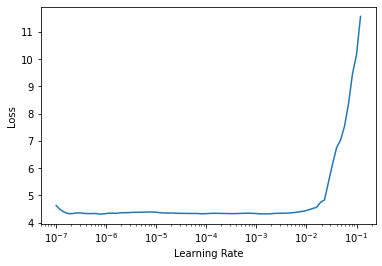

In [17]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,4.171999,3.876329,48.246773,00:44


## Ejemplo de generación de poema

In [19]:
prompt = 'love is ridiculous' # create an initial text prompt to start your generated text
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 3])

Agregar los argumentos `num_beams` y `no_repeat_ngram_size` hace una gran diferencia. Esto se puede explicar [aquí](https://huggingface.co/blog/how-to-generate). Básicamente, la búsqueda de beams reduce el riesgo de perder secuencias de palabras ocultas de alta probabilidad al mantener las num_beams hipótesis más probables en cada paso de tiempo y finalmente elegir la hipótesis que tiene la probabilidad general más alta. Sin la búsqueda de beams, obtendrías una búsqueda más codiciosa. La búsqueda de beams siempre encontrará una secuencia de salida con una probabilidad más alta que la búsqueda codiciosa, pero no se garantiza que encuentre la salida más probable. Además, sin el argumento no_repeat_ngram_size, es probable que obtengas una salida repetida. Por lo tanto, agregamos una penalización que asegura que ningún n-grama aparezca dos veces al establecer manualmente la probabilidad de las siguientes palabras que podrían crear un n-grama ya visto en 0. 

In [20]:
preds = learn.model.generate(inp, max_length=60, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
love is ridiculous.
"I am not a fool,
But I am a man of good will."
And he said, "I have done my duty, and I will do it again."


CHAPTER VIII

The day of the battle
As the sun rose in the sky


In [21]:
prompt = "Hay cosas en la vida yo no se"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp, max_length=60, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
Hay cosas en la vida yo no segundo.
"I am not a man of the world,
But I am a woman of God."
And he said, "I have a wife and a son, and I shall have them soon."


CHAPTER VIII


